# <font color='blue'>Computer Vision: Final Project - cars detection </font>

Submitted by:  **Inbal Mishal** 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

# set the default color-map of plt.image() to 'gray'
plt.rc('image', cmap='gray')

# set a bigger default figure size
plt.rc('figure', figsize=[10,10])

***
### The original video:

In [2]:
# Get the video capture
cap = cv2.VideoCapture('P1_roundabout.mp4')
while True:
    # Read next frame
    ret, frame = cap.read() 
    
    if ret==True:
        cv2.imshow('original', frame)
        
        # If ESC key pressed then do break
        if (cv2.waitKey(1) & 0xff == 27): 
            break
    # If the video was ended then ret=false and do break
    else:
        break

cap.release() # release input video
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);

***
### Part I: Video stabilization 

We are going to use the first frame of the video as our reference frame. 

Next, we can estimate the transformation between each of the frames in the video and the reference frame. 

Finally, we will use these transformations, to transform each and every frame towards our reference frame, eliminating all camera movements.


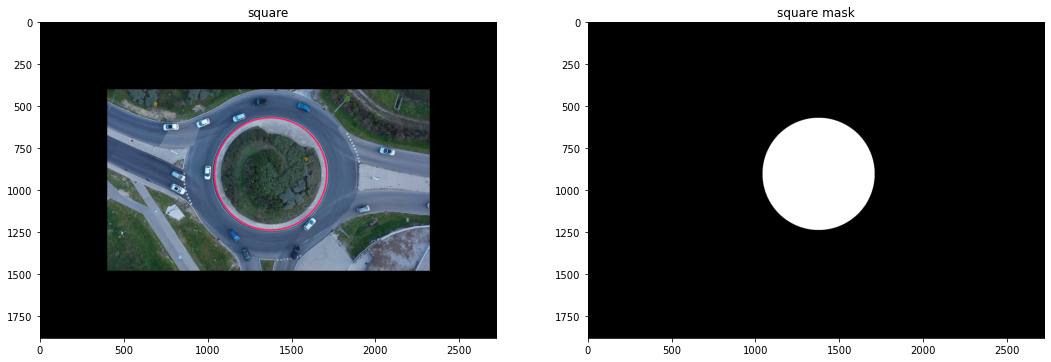

-1

In [3]:
# Make a black border to the video in order to see all of the frames after the video stabilization.
border_size = 400

# Get the video capture
cap = cv2.VideoCapture('P1_roundabout.mp4')
# Get the video width
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# Get the video heigh
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Read the first frame
ret, frame1 = cap.read()
frame1_border = cv2.copyMakeBorder(frame1, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT)
frame1_gray = cv2.cvtColor(frame1_border, cv2.COLOR_BGR2GRAY)

# Use HoughCircles to find the square. We need the squar because it doesn't change it's place during the video and
# thats why it can help us to stabilize the video.
square = cv2.HoughCircles(frame1_gray,method=cv2.HOUGH_GRADIENT,dp=1,minDist=10000,
                           param1=100,param2=20,minRadius=300,maxRadius=335)

square = square.astype(np.int)

# Create two images in oreder to see the result - 
# One of the circle that fits to the square (= square mask) and one of the first frame and the surrounded square.
black = np.zeros_like(frame1_gray)
black_bgr = cv2.cvtColor(black, cv2.COLOR_GRAY2BGR)
frame1_border =  cv2.cvtColor(frame1_border, cv2.COLOR_BGR2RGB)

# Draw the relevant circle on each image.
for (x,y,r) in square[0]:
    cv2.circle(frame1_border,(x,y),r,(255,30,100),7)
    cv2.circle(black_bgr,(x,y),r,(255,255,255),-1)

# Plot the results:
plt.figure(figsize=(18,13))

plt.subplot(1,2,1)
plt.title('square')
plt.imshow(frame1_border)

plt.subplot(1,2,2)
plt.title('square mask')
square_mask = cv2.cvtColor(black_bgr, cv2.COLOR_BGR2GRAY)
plt.imshow(square_mask)

plt.show()
cap.release() # closes video file
cv2.waitKey(1)

Create a stable video by using corner detection and find the homography between each frame to the first frame. 
This video will be with the corners points.


In [4]:
# Set the border size
border_size = 400

# Get the video capture, width, heigth and fps
cap = cv2.VideoCapture('P1_roundabout.mp4')
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)

# Set the type, size, fps and name of the stable video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('stable_roundabout_points.mp4',fourcc, FPS, (W+2*border_size,H+2*border_size))

# Parameters for font
font_params = dict(org = (30,30),
                   fontFace = cv2.FONT_HERSHEY_PLAIN,
                   fontScale = 1,
                   color = (0,255,255),
                   lineType = 1)

# Parameters for corner detection:
feature_params = dict( maxCorners = 3000,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 5)

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
ret, frame1 = cap.read()
frame1_border = cv2.copyMakeBorder(frame1, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT)
frame1_gray = cv2.cvtColor(frame1_border, cv2.COLOR_BGR2GRAY)

# Use the square mask to find the square:
pts0 = cv2.goodFeaturesToTrack(frame1_gray, mask = square_mask, **feature_params)

# Print the frame with the points in the notebook
for p in pts0:
    x,y = p.squeeze().astype(np.int)
    frame1_border = cv2.circle(frame1_border,(int(x), int(y)),2,(255,100,200),-1) # new points
cv2.imshow('stable_roundabout_window_points',frame1_border) 
out.write(frame1_border)  
cv2.waitKey(1)

# Update the old frame and the old pts
old_gray_frame = frame1_gray
old_pts = pts0.copy()

# Stabilize each frame according to the first frame
while True:
    # Read new frame
    ret, frame = cap.read()
    
    if ret==True:
        # Create a border to the new frame
        frame_border = cv2.copyMakeBorder(frame, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT)
        frame_gray = cv2.cvtColor(frame_border, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow:
        pts1, status, err = cv2.calcOpticalFlowPyrLK(old_gray_frame, frame_gray, old_pts, None, **lk_params)
        
        # Delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        
        # Calaulate the homography
        H, mask = cv2.findHomography(pts1, pts0, cv2.RANSAC, 30.0)
        
        # Get the rotated frame (after the stabilization)
        warped = cv2.warpPerspective(frame_border, H, (frame1_border.shape[1], frame1_border.shape[0]))
       
        # Draw the corner points
        for p1 in pts1:
            x1,y1 = p1.squeeze().astype(np.int)
            pts = np.int32([[x1,y1]]).reshape(-1,1,2)            
            dst = cv2.perspectiveTransform(pts.astype(np.float),H)
            x1 = dst[0][0][0]
            y1 = dst[0][0][1]
            warped = cv2.circle(warped,(int(x1), int(y1)),2,(255,100,200),-1) # new points
            
        # Add the number of the points on the video
        cv2.putText(warped,str(pts0.size//2) + ' pts', **font_params)                        
        
        # Show and record the video
        cv2.imshow('stable_roundabout_window_points',warped)  
        out.write(warped)
        
        # Update the old frame and the old pts
        old_gray_frame = frame_gray
        old_pts = pts1.copy()
        
        if(cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
            
    else: # (ret==False)
        break

out.release() # release output video
cap.release() # closes video file
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);

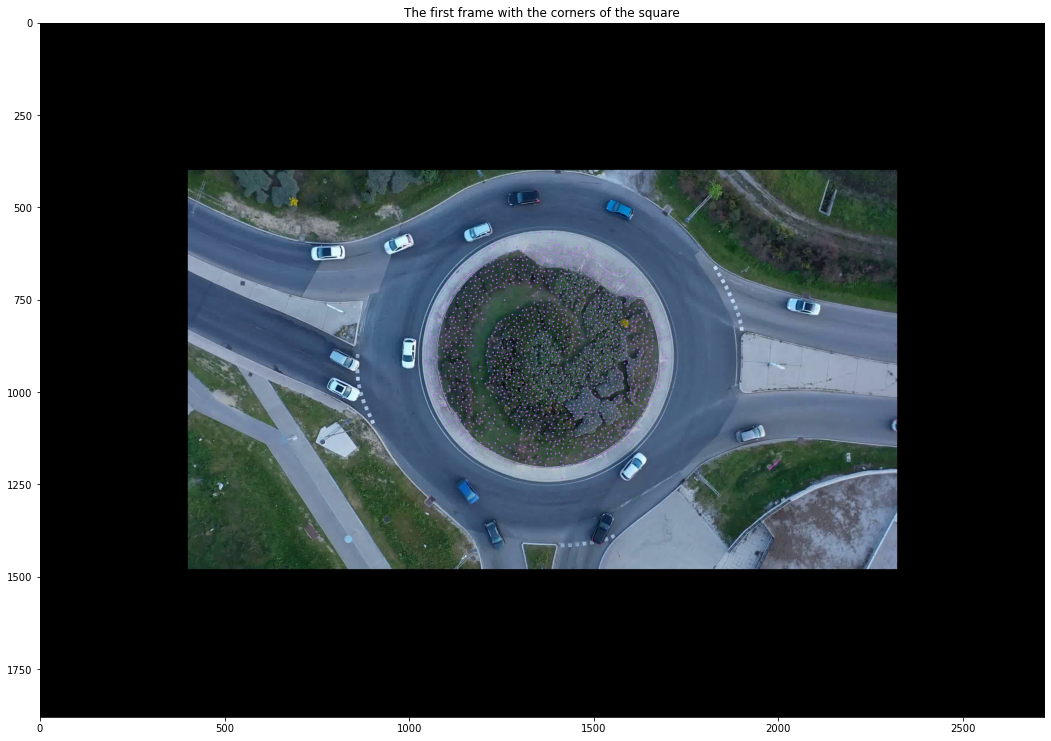

-1

In [5]:
# watch the corners that we found on the first frame:
cap = cv2.VideoCapture('stable_roundabout_points.mp4')

ret, frame1 = cap.read()

if ret == True:
    frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize=(18,13))
plt.title('The first frame with the corners of the square')
plt.imshow(frame)
plt.show()

cap.release() # closes video file
cv2.waitKey(1)

Create the same video but without the corner points 

In [6]:
border_size = 400

# Get the video capture, width, heigth and fps
cap = cv2.VideoCapture('P1_roundabout.mp4')
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)

# Set the type, size, fps and name of the stable video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('stable_roundabout.mp4',fourcc, FPS, (W+2*border_size,H+2*border_size))

# params for corner detection:
feature_params = dict( maxCorners = 3000,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 5)

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
ret, frame1 = cap.read()
frame1_border = cv2.copyMakeBorder(frame1, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT)
frame1_gray = cv2.cvtColor(frame1_border, cv2.COLOR_BGR2GRAY)

# Use the square mask to find the square:
pts0 = cv2.goodFeaturesToTrack(frame1_gray, mask = square_mask, **feature_params)

# Print the first frame
cv2.imshow('stable_roundabout_window',frame1_border) 
out.write(frame1_border)  
cv2.waitKey(1)

# Update the old frame and the old points
old_gray_frame = frame1_gray
old_pts = pts0.copy()

# Stabilize the frames according to the first frame
while True:
    # Read new frame
    ret, frame = cap.read()
    
    if ret==True:
        # Create a border to the new frame
        frame_border = cv2.copyMakeBorder(frame, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT)
        frame_gray = cv2.cvtColor(frame_border, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow:
        pts1, status, err = cv2.calcOpticalFlowPyrLK(old_gray_frame, frame_gray, old_pts, None, **lk_params)
        
        # Delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        
        # Calaulate the homography
        H, mask = cv2.findHomography(pts1, pts0, cv2.RANSAC, 30.0)
        
        # Get the rotated frame (after the stabilization)
        warped = cv2.warpPerspective(frame_border, H, (frame1_border.shape[1], frame1_border.shape[0]))                       
        
        # Show and record the video
        cv2.imshow('stable_roundabout_window',warped)  
        out.write(warped)
        
        # Update the old frame and the old pts
        old_gray_frame = frame_gray
        old_pts = pts1.copy()
        
        if(cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
            
    else: # (ret==False)
        break

out.release() # release output video
cap.release() # closes video file
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);

***
### Part II: Find The Edges 

we will make a video of the rotated edges.



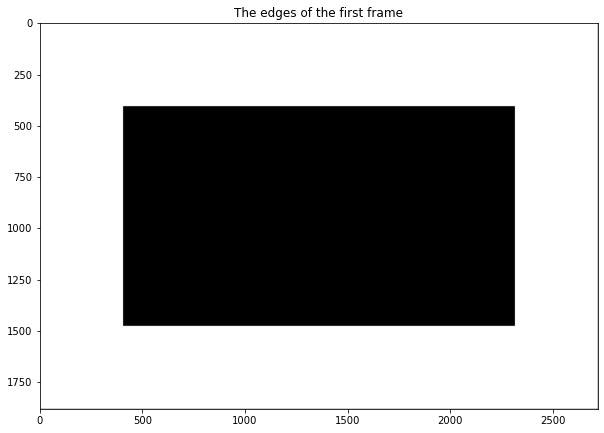

In [7]:
border_size = 400

# Get the video capture, width, heigth and fps
cap = cv2.VideoCapture('P1_roundabout.mp4')
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
edges = np.zeros((H+2*border_size,W+2*border_size), dtype=np.uint8)

# Get the edges of the first frame with an "extra edge" of 5 pixels from each side
extra_edge = 5
edges[0:border_size+extra_edge,0:W+2*border_size-1]=255
edges[border_size+H-extra_edge:H+2*border_size-1,0:W+2*border_size-1]=255
edges[0:H+2*border_size-1,0:border_size+extra_edge]=255
edges[0:H+2*border_size-1,border_size+W-extra_edge:W+2*border_size-1]=255

plt.title('The edges of the first frame')
plt.imshow(edges)
plt.show()

In [8]:
# Create a video of the rotated edges
border_size = 400

# Get the video capture, width, heigth and fps
cap = cv2.VideoCapture('P1_roundabout.mp4')
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Set the video capture, width, heigth and fps
out = cv2.VideoWriter('edges.mp4',fourcc, FPS, (W+2*border_size,H+2*border_size))

# Parameters for corner detection:
feature_params = dict( maxCorners = 3000,
                       qualityLevel = 0.01,
                       minDistance = 10,
                       blockSize = 5)

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
ret, frame1 = cap.read()
frame1_border = cv2.copyMakeBorder(frame1, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT)
frame1_gray = cv2.cvtColor(frame1_border, cv2.COLOR_BGR2GRAY)

# Use the mask to find the square:
pts0 = cv2.goodFeaturesToTrack(frame1_gray, mask = square_mask, **feature_params)

# Create the first edges image
edges = np.zeros((H+2*border_size,W+2*border_size), dtype=np.uint8)
extra_edge = 5
edges[0:border_size+extra_edge,0:W+2*border_size-1]=255
edges[border_size+H-extra_edge:H+2*border_size-1,0:W+2*border_size-1]=255
edges[0:H+2*border_size-1,0:border_size+extra_edge]=255
edges[0:H+2*border_size-1,border_size+W-extra_edge:W+2*border_size-1]=255

# Print and record the first frame
edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
cv2.imshow('edges',edges) 
out.write(edges)  
cv2.waitKey(1)

# Update the old frame and the old pts
old_gray_frame = frame1_gray
old_pts = pts0.copy()
    
while True:
    # Read new frame
    ret, frame = cap.read()
    
    if ret==True:
        # Create a border to the new frame
        frame_border = cv2.copyMakeBorder(frame, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT)
        frame_gray = cv2.cvtColor(frame_border, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow:
        pts1, status, err = cv2.calcOpticalFlowPyrLK(old_gray_frame, frame_gray, old_pts, None, **lk_params)
        
        # Delete "failed" points (status==0)
        pts1 = pts1[status[:,0]==1]
        pts0 = pts0[status[:,0]==1]
        
        # Calaulate the homography
        H, mask = cv2.findHomography(pts1, pts0, cv2.RANSAC, 30.0)
        
        # Get the rotated frame (after the stabilization)
        warped = cv2.warpPerspective(edges, H, (frame1_border.shape[1], frame1_border.shape[0]))                       
        
        # Show and record the video
        cv2.imshow('edges',warped)  
        out.write(warped)
        
        # Update the old frame and the old pts
        old_gray_frame = frame_gray
        old_pts = pts1.copy()
        
        if(cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
            
    else: # (ret==False)
        break

out.release() # release output video
cap.release() # closes video file
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);

***
### Part III: Cars detection

Now, that we have a stabilized video, we will  track individual cars in the movie.

First, we will make a mask video. This mask will help us to check that the cars are still in the image.

The video will not be completely accurate so that all the cars will appear in it all the time and it will be used by us to delete irrelevant points of interest. During the finding of the contours we will use a more accurate function.

In [9]:
# Ignore non- important areas
def get_non_important_mask(H,W):
    mask_non_important = np.zeros((H,W), dtype=np.uint8)
    mask_non_important[0:420,0:W] = 255
    mask_non_important[0:H,W-450:W] = 255
    mask_non_important[0:H,0:450] = 255
    mask_non_important[0:500,0:1000] = 255
    mask_non_important[0:600, W-900:W] = 255
    mask_non_important[H-650:H, 0:950] = 255
    mask_non_important[H-650:H, W-950:W] = 255
    mask_non_important[H-600:H, 0:1100] = 255
    mask_non_important[H-800:H, 0:800] = 255
    mask_non_important[int(H/2)-40:int(H/2)+40, W-700:W] = 255
    mask_non_important[int(H/2)-180:int(H/2)-80, 790:850] = 255
    mask_non_important[square_mask==255] = 255
    return mask_non_important

create cars mask video:

In [10]:
# Cars mask video
cap = cv2.VideoCapture('stable_roundabout.mp4')
edges_cap = cv2.VideoCapture('edges.mp4')

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
k1 = np.ones((3,3),np.uint8)

FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter('cars_mask.mp4',fourcc, FPS, (W,H))

# Get mask of non-important areas
mask_non_important = get_non_important_mask(H, W)

# Read the first frame
ret, frame1 = cap.read()
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)


is_first_frame = True  
while True:
    # Calculate the cars mask according to the difference between 2 unfollowing frames (there is a frame between them).
    if not is_first_frame:
        # a and b helps use to skip over one frame and calaulate the difference between 2 unfollowing frames
        _,b = edges_cap.read()
        _,a = cap.read()
    is_first_frame = False
    
    _, edge = edges_cap.read()
    ret, frame2 = cap.read()
    
    if ret==True:
        
        # Convert to binary 
        edge_gray = cv2.cvtColor(edge, cv2.COLOR_BGR2GRAY)
        edge_gray[edge_gray>20] = 255
        edge_gray[edge_gray<=20] = 0
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
                       
        car_mask = np.zeros_like(frame2)
        frame_with_contur = frame2.copy()
        
        # Ignor the non-important areas
        gray1[mask_non_important == 255]=0
        gray2[mask_non_important == 255]=0
        
        # Get the changes between frames
        frameDelta = cv2.absdiff(gray1, gray2)
        
        # Delete the edges of the image
        frameDelta[edge_gray==255]=0
        
        ret, thresh = cv2.threshold(frameDelta, 20, 200, cv2.THRESH_BINARY)
        dilatedFrame = cv2.dilate(thresh, k1, iterations = 8)

        # Find the conturs of the cars
        ctrs, _ = cv2.findContours(dilatedFrame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        CNTS = []
        
        # Filter the contours by area and length to width ratio
        for i in range(0,len(ctrs)):
            ctr = ctrs[i]
            M = cv2.moments(ctr)
            if(2000<M["m00"]):
                rot_rect = cv2.minAreaRect(ctr)
                _, (w,h), _ = rot_rect
                box = np.int64(cv2.boxPoints(rot_rect))
                if(((0<w-h<200) or (-200<w-h<0)) and (900<w*h)):
                    CNTS.append(ctr)
    
        cv2.drawContours(car_mask, CNTS, -1, (255, 255, 255), -1)
        cv2.drawContours(frame_with_contur, CNTS, -1, (100, 30, 255), 5)
        
        
        # Print and record each frame twice in order to keep the original video length 
        cv2.imshow('video_with_conturs',frame_with_contur)
        cv2.imshow('video_with_conturs',frame_with_contur)
        cv2.imshow('carsmask',car_mask)
        cv2.imshow('carsmask',car_mask)
        out.write(car_mask)
        out.write(car_mask)
        
        # Update the old gray frame 
        gray1 = gray2

        if(cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
            
    else: # (ret==False)            
        break

out.release() # release output video
cap.release() # closes video file
edges_cap.release() # closes video file
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);

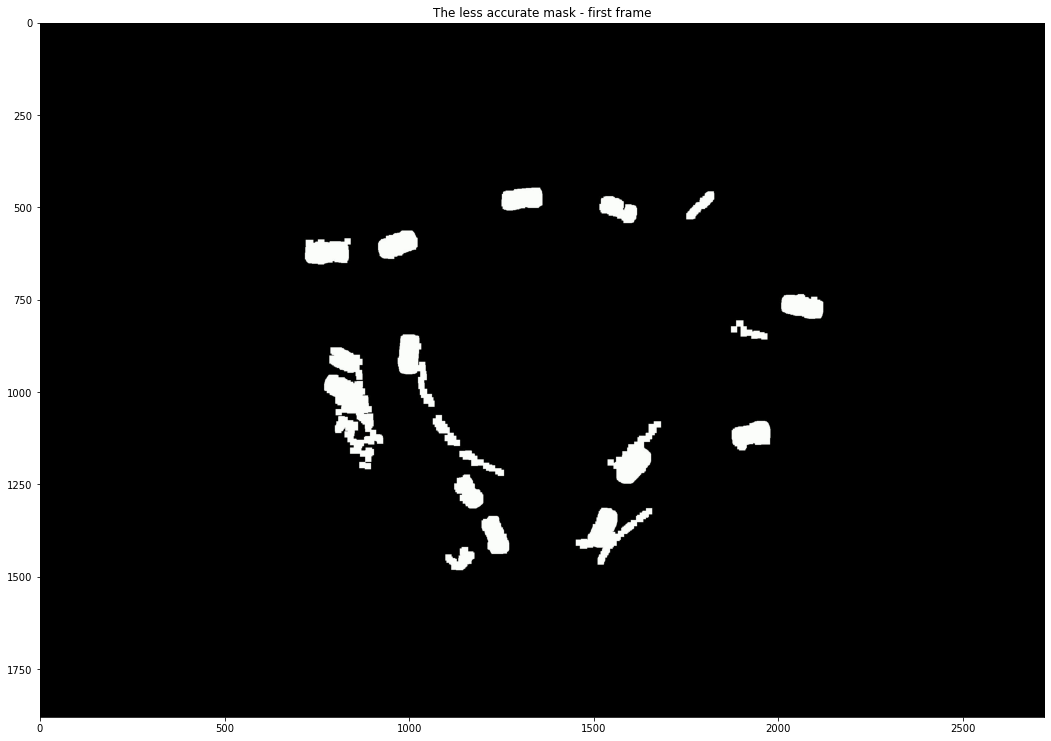

-1

In [11]:
# Watch the less accurate mask that we found on the first frame:
cap = cv2.VideoCapture('cars_mask.mp4')

ret, frame1 = cap.read()

if ret == True:
    frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize=(18,13))
plt.title('The less accurate mask - first frame')
plt.imshow(frame)
plt.show()

cap.release() # closes video file
cv2.waitKey(1)

The following function search for accurate conturs in the frame:

In [12]:
# This function search for accurate conturs in the frame
def find_conturs(gray1, gray2, edges, mask_old_cars):
    k1 = np.ones((3,3),np.uint8)
    W = int(gray1.shape[1])
    H = int(gray1.shape[0])
    
    non_important_mask = get_non_important_mask(H,W)

    gray1[non_important_mask ==255]=0
    gray2[non_important_mask ==255]=0
    
    # Get the changes between frames
    frameDelta = cv2.absdiff(gray1, gray2)
    
    # Delete (=make black) the edges of the image
    frameDelta[edges==255]=0
    
    # Delete (=make black) old cars
    frameDelta[mask_old_cars==255]=0

    ret, thresh = cv2.threshold(frameDelta, 38, 200, cv2.THRESH_BINARY)
    dilatedFrame = cv2.dilate(thresh, k1, iterations = 11)

    ctrs, _ = cv2.findContours(dilatedFrame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    CNTS = []
    
    # Filter the contours by area and length to width ratio
    for i in range(0,len(ctrs)):
        ctr = ctrs[i]
        M = cv2.moments(ctr)
        if(2000<M["m00"]):
            rot_rect = cv2.minAreaRect(ctr)
            _, (w,h), _ = rot_rect
            box = np.int64(cv2.boxPoints(rot_rect))
            if(((0<w-h<80) or (-80<w-h<0)) and (900<w*h)):
                CNTS.append(ctr)
    
    return CNTS

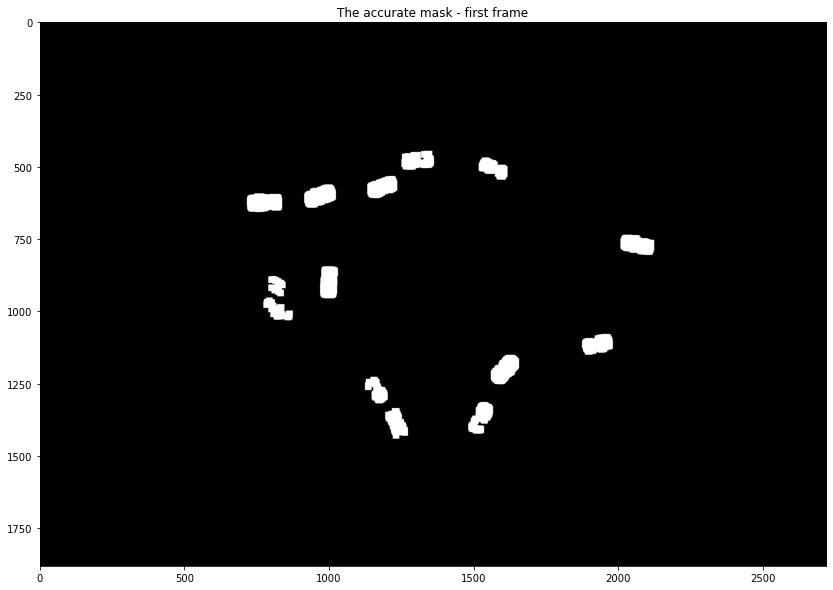

-1

In [13]:
# Example: the fundtion "find_conturs" and the first frame
cap = cv2.VideoCapture('stable_roundabout.mp4')
edges_cap = cv2.VideoCapture('edges.mp4')

# Get the current edges
ret, edges1 = edges_cap.read()
edges1_gray = cv2.cvtColor(edges1, cv2.COLOR_BGR2GRAY)

# Convert to binary
edges1_gray[edges1_gray>20] = 255
edges1_gray[edges1_gray<=20] = 0

# Get the current frame
ret, frame1 = cap.read()
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
ret, frame2 = cap.read()
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
car_mask = np.zeros_like(frame2)

black = np.zeros_like(gray2)
CNTS = find_conturs(gray1, gray2, edges1_gray, black)
    
cv2.drawContours(car_mask, CNTS, -1, (255, 255, 255), -1)

plt.figure(figsize=(15,10))
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
plt.title('The accurate mask - first frame')
plt.imshow(car_mask)
plt.show()

edges_cap.release() # closes video file
cv2.waitKey(1) 
cap.release() # closes video file
cv2.waitKey(1) 

### The final result:

In [14]:
# Open several videos that will help us
cap = cv2.VideoCapture('stable_roundabout.mp4')
car_mask_cap = cv2.VideoCapture('cars_mask.mp4')
edges_cap = cv2.VideoCapture('edges.mp4')

# Get the video capture, width, heigth and fps
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# set the video capture, width, heigth and fps
out = cv2.VideoWriter('final_detection.mp4',fourcc, FPS, (W,H))

# Parameters for corner detection
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.1,
                       minDistance = 10,
                       blockSize = 3 )

# Parameters for optical flow
lk_params = dict( winSize  = (10,10),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Parameters for font
font_params = dict(org = (30,30),
                   fontFace = cv2.FONT_HERSHEY_PLAIN,
                   fontScale = 1,
                   color = (0,255,255),
                   lineType = 1)

# Read the first car mask
ret, car_mask = car_mask_cap.read()
car_mask_gray = cv2.cvtColor(car_mask, cv2.COLOR_BGR2GRAY)

# Convert to binary
car_mask_gray[car_mask_gray>20] = 255
car_mask_gray[car_mask_gray<=20] = 0

# Read the first edge
ret, edges1 = edges_cap.read()
edges1_gray = cv2.cvtColor(edges1, cv2.COLOR_BGR2GRAY)

# Convert to binary
edges1_gray[edges1_gray>0] = 255

# Take the first and the second frames and find corners in them for each contur
ret, F0 = cap.read()
F0_gray = cv2.cvtColor(F0, cv2.COLOR_BGR2GRAY)
ret, F1 = cap.read()
F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)
mask1 = np.zeros_like(F0)
mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)

CNTS = find_conturs(F0_gray.copy(), F1_gray.copy(), edges1_gray.copy(), mask1.copy())

# Create the car list and match to each car corners, id and color
cars = []
id = 1
for i in range(0, len(CNTS)):
    black = np.zeros((H,W), dtype=np.uint8)
    black =  cv2.cvtColor(black, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(black, CNTS, i, (200,200,200), -1)
    black =  cv2.cvtColor(black, cv2.COLOR_BGR2GRAY)
    
    pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = black, **feature_params)
    color = (random.randint(10,230), random.randint(10,220), random.randint(10,240))
    car = (id, pts0, color)
    cars.append(car)
    id = id + 1
    
# Create a mask image for drawing purposes
canvas = np.zeros_like(F0)

# Create a flag that will help us to find conturs in the middle of the video
flag = 0

while(True):
    # This mask represent the old cars. when we will try to find new cars we want to ignore the old cars.
    mask1 = np.zeros_like(F0)
    
    # If we are not in the beginning
    if flag != 0:
        # Read new edge
        _,edges1 = edges_cap.read()
        
        # Read new car mask
        _, car_mask = car_mask_cap.read()
        
        # Read new frame
        ret,F1 = cap.read()
        
    flag = flag + 1
    
    if ret==True:
        edges1_gray = cv2.cvtColor(edges1, cv2.COLOR_BGR2GRAY)
        
        # Convert to binary
        edges1_gray[edges1_gray>0] = 255
        
        car_mask_gray = cv2.cvtColor(car_mask, cv2.COLOR_BGR2GRAY)
        
        # Convert to binary
        car_mask_gray[car_mask_gray>20] = 255
        car_mask_gray[car_mask_gray<=20] = 0
        
        F1_gray = cv2.cvtColor(F1, cv2.COLOR_BGR2GRAY)
        
        # Create a list of cars that we need to delete
        delete_car = []

        # Calculate optical flow for each contur
        for i in range(0, len(cars)):
            car_id = cars[i][0]
            pts0 = cars[i][1]
            car_color = cars[i][2]
            pts1, status, err = cv2.calcOpticalFlowPyrLK(F0_gray, F1_gray, pts0, None, **lk_params) 
            
            # If there are no pts in the car conture so we need to delete the car.
            if pts1 is None:
                car = (car_id, pts0, car_color)
                delete_car.append(car)
            else:
                sum_x = 0
                sum_y = 0
                count = 0
                
                for p1,s in zip(pts1,status):
                    x1,y1 = p1.squeeze().astype(np.int)
                    
                    # If point exceeded from the frame                       
                    if (y1 > H) or (x1 > W):
                        s[0]=0
                    
                    # Checks if the point is on car
                    else:
                        if car_mask_gray[y1][x1] == 0:
                            s[0] = 0
                        else:
                            sum_x = sum_x + x1
                            sum_y = sum_y + y1
                            count = count + 1
                            
                            # Prints the points
                            mask1 = cv2.circle(mask1,(x1,y1),45,(255,255,255),-1)
                            canvas = cv2.circle(canvas,(x1,y1),5,car_color,-1)
                    
                # Delete "failed" points (status==0)
                pts1 = pts1[status[:,0]==1]
                
                # If after the cleaning of the "failed" points there is no pts in the car contur
                if pts1 is None:
                    car = (car_id, pts0, car_color)
                    delete_car.append(car)
                else:
                    cars[i] = (car_id, pts1, car_color)
                    text = 'id: ' + str(car_id)
                    if count != 0:
                        # Prints the id in the center of the points
                        cv2.putText(F1, text , (int(sum_x/count),int(sum_y/count)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (50,50,200), 3)
        
        # Delete irrelevant cars
        for car in delete_car:
            cars.remove(car)
        
        # After 10 steps we try to find new cars
        if (flag==10):
            # Find new conturs without the old cars and add it to the cars list
            mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
            CNTS = find_conturs(F0_gray.copy(), F1_gray.copy(), edges1_gray.copy(), mask1.copy())
            
            for i in range(0, len(CNTS)):
                black = np.zeros((H,W), dtype=np.uint8)
                black =  cv2.cvtColor(black, cv2.COLOR_GRAY2BGR)
                cv2.drawContours(black, CNTS, i, (200,200,200), -1)
                black =  cv2.cvtColor(black, cv2.COLOR_BGR2GRAY)
    
                pts0 = cv2.goodFeaturesToTrack(F0_gray, mask = black, **feature_params)
                color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
                car = (id, pts0, color)
                cars.append(car)
                id = id+1   
            flag = 1
        
        canvas = np.uint8(canvas*0.85) # fade out canvas  
        F1 = cv2.add(F1, canvas)
        cv2.imshow('final',F1)
        out.write(F1)
       
        # Now update the previous frame and previous points
        F0_gray = F1_gray
      
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
            
    else: # no frames to read
        break

out.release()  # closes video file
car_mask_cap.release()  # closes video file
edges_cap.release()  # closes video file
cap.release() # closes video file
cv2.destroyAllWindows()  # delete output window
cv2.waitKey(1)

-1

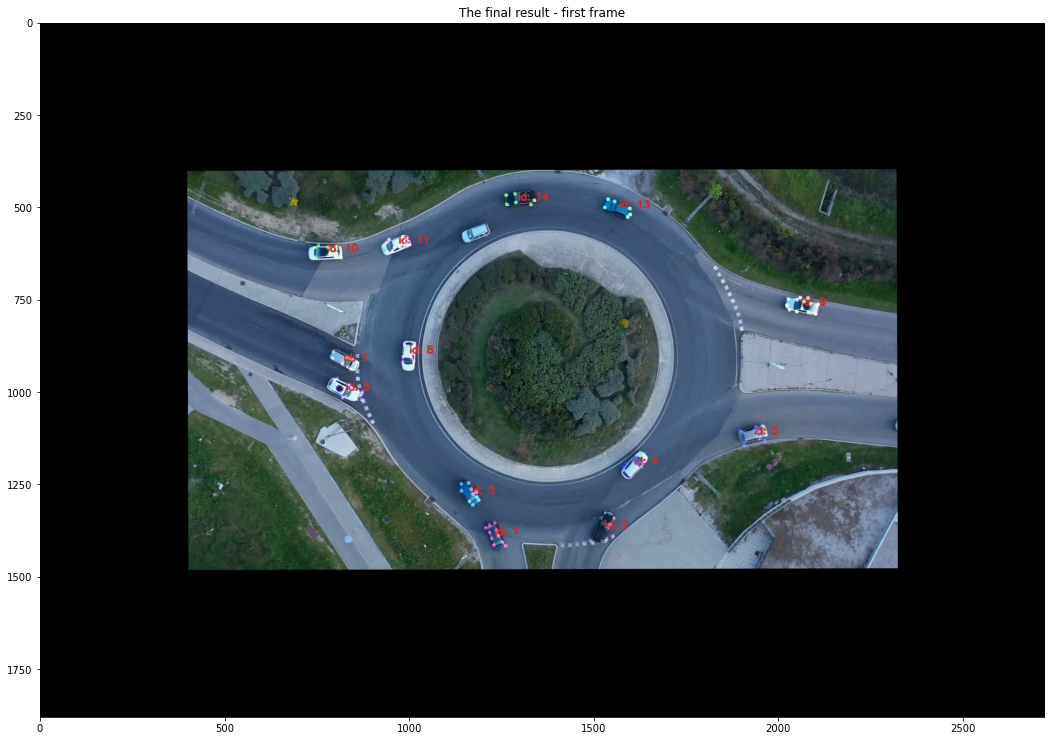

-1

In [15]:
# Print the first frane result
cap = cv2.VideoCapture('final_detection.mp4')

ret, frame1 = cap.read()

if ret == True:
    frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    
plt.figure(figsize=(18,13))
plt.title('The final result - first frame')
plt.imshow(frame)
plt.show()

cap.release() # closes video file
cv2.waitKey(1)

THE END!